In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import models,layers
from imgaug import augmenters as iaa
import imgaug as ia
from sklearn.metrics import classification_report
import itertools

In [2]:
df = pd.read_csv('../input/isic-2019-challenge/ISIC_2019_Training_GroundTruth.csv')
df_train = pd.read_csv('../input/pastas-de-dados/df_train.csv')
df_val = pd.read_csv('../input/pastas-de-dados/df_val.csv')
df_test = pd.read_csv('../input/pastas-de-dados/df_test.csv')

base_dir = '../input/isic-2019-challenge/ISIC_2019_Training_Input/ISIC_2019_Training_Input'

In [3]:
df_train.drop(df_train.loc[df_train['NV']==1.0].index,inplace=True)
df_train.drop(df_train.loc[df_train['AK']==1.0].index,inplace=True)
df_train.drop(df_train.loc[df_train['BKL']==1.0].index,inplace=True)
df_train.drop(df_train.loc[df_train['DF']==1.0].index,inplace=True)
df_train.drop(['NV','AK','BKL','DF'],axis=1,inplace=True)

In [4]:
df_val.drop(df_val.loc[df_val['NV']==1.0].index,inplace=True)
df_val.drop(df_val.loc[df_val['AK']==1.0].index,inplace=True)
df_val.drop(df_val.loc[df_val['BKL']==1.0].index,inplace=True)
df_val.drop(df_val.loc[df_val['DF']==1.0].index,inplace=True)
df_val.drop(['NV','AK','BKL','DF'],axis=1,inplace=True)

In [5]:
df_test.drop(df_test.loc[df_test['NV']==1.0].index,inplace=True)
df_test.drop(df_test.loc[df_test['AK']==1.0].index,inplace=True)
df_test.drop(df_test.loc[df_test['BKL']==1.0].index,inplace=True)
df_test.drop(df_test.loc[df_test['DF']==1.0].index,inplace=True)
df_test.drop(['NV','AK','BKL','DF'],axis=1,inplace=True)

In [6]:
tf.random.set_seed(42)
ia.seed(42)

rand_aug = iaa.RandAugment(n=1, m=2)

def augment(image):
    image = tf.cast(image, tf.uint8)
    return rand_aug(image=image.numpy())

def random_crop(image,aspect_ratio_range=[0.75, 1.33],area_range=[0.08, 1],min_object_covered=0.5,max_attempts=100,seed=0):
    bbox = tf.constant([0.0, 0.0, 1.0, 1.0], dtype=tf.float32, shape=[1, 1, 4])
    bbox_begin, bbox_size, _ = tf.image.sample_distorted_bounding_box(
    tf.shape(image),
    bounding_boxes=bbox,
    min_object_covered=min_object_covered,
    area_range=area_range,
    aspect_ratio_range=aspect_ratio_range,
    use_image_if_no_bounding_boxes=True,
    max_attempts=max_attempts,
    seed=seed)
    offset_height, offset_width, _ = tf.unstack(bbox_begin)
    target_height, target_width, _ = tf.unstack(bbox_size)

    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    image = tf.image.crop_to_bounding_box(image,offset_height,offset_width,target_height,target_width)

    return image

In [7]:
def loadImage(image,mel,bcc,vasc,scc):
 image = tf.io.read_file(base_dir + '/' + image + '.jpg')
 image = tf.io.decode_jpeg(image,channels=3)
 

 label = tf.stack([mel,bcc,vasc,scc])
 return image,label


def dataAument(image,label):
 image = random_crop(image)
 image = tf.image.convert_image_dtype(image, dtype=tf.float32)
 image = tf.image.resize(image,size = (224,224)) #EfficientNetB2
 image = tf.image.random_flip_left_right(image)
 image = tf.image.random_flip_up_down(image)
 image_shape = tf.shape(image)
 image = tf.image.convert_image_dtype(image, dtype=tf.uint8)
 image2 = tf.py_function(augment,[image],[tf.float32])[0]
 image = tf.ensure_shape(image2,shape=image.get_shape())

 return image,label
 
def resize(image,label):
    image = tf.image.resize(image,size = (224,224)) #EfficientNetB0

    return image,label

In [8]:
dataSet_train = tf.data.Dataset.from_tensor_slices((df_train['image'],
                                                    df_train['MEL'],
                                                    df_train['BCC'],
                                                    df_train['VASC'],
                                                    df_train['SCC']))
dataSet_train = dataSet_train.shuffle(len(df_train))
dataSet_train = dataSet_train.map(loadImage)
dataSet_train = dataSet_train.map(dataAument)

dataSet_train = dataSet_train.batch(64)

2022-01-31 09:17:42.082230: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-31 09:17:42.176606: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-31 09:17:42.177337: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-31 09:17:42.179952: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [9]:
dataSet_val = tf.data.Dataset.from_tensor_slices((df_val['image'],
                                                    df_val['MEL'],
                                                    df_val['BCC'],
                                                    df_val['VASC'],
                                                    df_val['SCC']))
dataSet_val = dataSet_val.map(loadImage)
dataSet_val = dataSet_val.map(resize)
dataSet_val = dataSet_val.batch(64)

In [10]:
dataSet_test = tf.data.Dataset.from_tensor_slices((df_test['image'],
                                                    df_test['MEL'],
                                                    df_test['BCC'],
                                                    df_test['VASC'],
                                                    df_test['SCC']))
dataSet_test = dataSet_test.map(loadImage)
dataSet_test = dataSet_test.map(resize)
dataSet_test = dataSet_test.batch(64)

2022-01-31 09:17:44.823384: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


(64, 224, 224, 3)


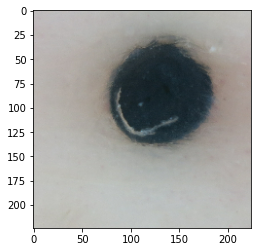

In [11]:
for sample in dataSet_test.take(1):
  print(sample[0].shape)
  plt.imshow(sample[0][0]/255)
  plt.show()

In [12]:
conv_base = EfficientNetB0(include_top=False,weights='imagenet',input_shape=(224,224,3))

conv_base.summary()

16719872/16705208 [==============================] - 0s 0us/step
Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
____________________

In [13]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(4, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 5124      
Total params: 4,054,695
Trainable params: 4,012,672
Non-trainable params: 42,023
_________________________________________________________________


In [14]:
model.compile(loss="categorical_crossentropy",optimizer='adam',metrics=["acc"])

H = model.fit(dataSet_train,epochs=40,validation_data = dataSet_val)

Epoch 1/40


2022-01-31 09:17:58.978012: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


109/109 [==============================] - 268s 2s/step - loss: 0.5703 - acc: 0.7901 - val_loss: 0.8146 - val_acc: 0.7040
Epoch 2/40
109/109 [==============================] - 213s 2s/step - loss: 0.3952 - acc: 0.8532 - val_loss: 0.4623 - val_acc: 0.8487
Epoch 3/40
109/109 [==============================] - 220s 2s/step - loss: 0.3365 - acc: 0.8744 - val_loss: 0.4107 - val_acc: 0.8543
Epoch 4/40
109/109 [==============================] - 221s 2s/step - loss: 0.2795 - acc: 0.8951 - val_loss: 0.3630 - val_acc: 0.8565
Epoch 5/40
109/109 [==============================] - 208s 2s/step - loss: 0.2703 - acc: 0.8989 - val_loss: 0.4166 - val_acc: 0.8565
Epoch 6/40
109/109 [==============================] - 219s 2s/step - loss: 0.2422 - acc: 0.9108 - val_loss: 0.3000 - val_acc: 0.9002
Epoch 7/40
109/109 [==============================] - 218s 2s/step - loss: 0.2242 - acc: 0.9193 - val_loss: 0.3421 - val_acc: 0.8789
Epoch 8/40
109/109 [==============================] - 225s 2s/step - loss: 0.186

In [15]:
#Save the entire model to a HDF5 file.
#The '.h5' extension indicates that the model should be saved to HDF5.
model.save('Class-MAL.h5')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [16]:
results = model.evaluate(dataSet_test)
print("test loss, test acc:", results)

14/14 [==============================] - 12s 867ms/step - loss: 0.4064 - acc: 0.8855
test loss, test acc: [0.4064239263534546, 0.8855218887329102]


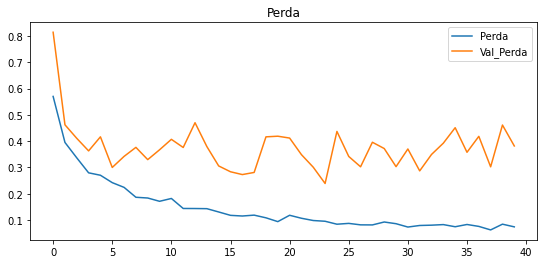

In [17]:
def print_curva(H):
    plt.figure(figsize=(20,4))
    plt.subplot(1,2,2)
    plt.plot(H.history['loss'], label='Perda')
    plt.plot(H.history['val_loss'], label='Val_Perda')
    plt.legend()
    plt.title('Perda')
    plt.show()

    
print_curva(H)

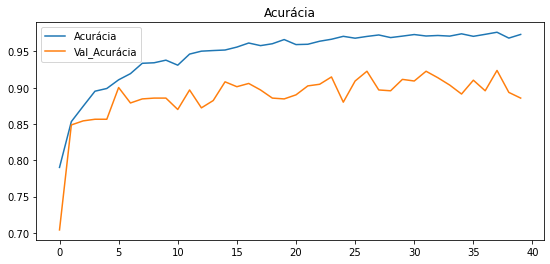

In [18]:
def print_curva2(H):
    plt.figure(figsize=(20,4))
    plt.subplot(1,2,2)
    plt.plot(H.history['acc'], label='Acurácia')
    plt.plot(H.history['val_acc'], label='Val_Acurácia')
    plt.legend()
    plt.title('Acurácia')
    plt.show()


print_curva2(H)